<a href="https://colab.research.google.com/github/fadibechara/Boltzmann_GPU/blob/main/Boltzmann_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import time
from math import sin, pi
from numba import cuda, float64
from matplotlib.pyplot import imshow

###### Flow definition #################################################
maxIter = 200000  # Total number of time iterations.
Re = 150.0         # Reynolds number.
nx, ny = 420, 180 # Numer of lattice nodes.
ly = ny-1         # Height of the domain in lattice units.
cx, cy, r = nx//4, ny//2, ny//9 # Coordinates of the cylinder.
uLB     = 0.04                  # Velocity in lattice units.
nulb    = uLB*r/Re;             # Viscoscity in lattice units.
omega = 1 / (3*nulb+0.5);    # Relaxation parameter.

###### Lattice Constants ###############################################
v = np.array([ [ 1,  1], [ 1,  0], [ 1, -1], [ 0,  1], [ 0,  0],
               [ 0, -1], [-1,  1], [-1,  0], [-1, -1] ])
t = np.array([ 1/36, 1/9, 1/36, 1/9, 4/9, 1/9, 1/36, 1/9, 1/36])

col1 = np.array([0, 1, 2])
col2 = np.array([3, 4, 5])
col3 = np.array([6, 7, 8])

In [3]:
def macroscopic(fin):
    """Compute macroscopic variables (density, velocity)

    fluid density is 0th moment of distribution functions 
    fluid velocity components are 1st order moments of fdist. functions
    """
    rho = np.sum(fin, axis=0)
    u = np.zeros((2, nx, ny))
    for i in range(9):
        u[0,:,:] += v[i,0] * fin[i,:,:]
        u[1,:,:] += v[i,1] * fin[i,:,:]
    u /= rho
    return rho, u
def equilibrium(rho, u):
    """Equilibrium distribution function.
    """
    usqr = 3/2 * (u[0]**2 + u[1]**2)
    feq = np.zeros((9,nx,ny))
    for i in range(9):
        cu = 3 * (v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i] * (1 + cu + 0.5*cu**2 - usqr)
    return feq

In [4]:

def obstacle_fun(x, y):
    return (x-cx)**2+(y-cy)**2<r**2

In [5]:
def inivel(d, x, y):
    return (1-d) * uLB * (1 + 1e-4*np.sin(y/ly*2*np.pi))

In [6]:
def main_cpu(max_iterations):

    # create obstacle mask array from element-wise function
    obstacle = np.fromfunction(obstacle_fun, (nx,ny))

    # initial velocity field vx,vy from element-wise function
    # vel is also used for inflow border condition
    vel = np.fromfunction(inivel, (2,nx,ny))

    # Initialization of the populations at equilibrium 
    # with the given velocity.
    fin = equilibrium(1, vel)

    ###### Main time loop ########
    for time in range(max_iterations):

        # Right wall: outflow condition.
        # we only need here to specify distrib. function for velocities
        # that enter the domain (other that go out, are set by the streaming step)
        fin[col3,nx-1,:] = fin[col3,nx-2,:] 

        # Compute macroscopic variables, density and velocity.
        rho, u = macroscopic(fin)

        # Left wall: inflow condition.
        u[:,0,:] = vel[:,0,:]
        rho[0,:] = 1/(1-u[0,0,:]) * ( np.sum(fin[col2,0,:], axis=0) +
                                      2*np.sum(fin[col3,0,:], axis=0) )
        
        # Compute equilibrium.
        feq = equilibrium(rho, u)
        fin[[0,1,2],0,:] = feq[[0,1,2],0,:] + fin[[8,7,6],0,:] - feq[[8,7,6],0,:]

        # Collision step.
        fout = fin - omega * (fin - feq)

        # Bounce-back condition for obstacle.
        # in python language, we "slice" fout by obstacle
        for i in range(9):
            fout[i, obstacle] = fin[8-i, obstacle]

        # Streaming step.
        for i in range(9):
            fin[i,:,:] = np.roll(np.roll(fout[i,:,:], v[i,0], axis=0),
                                 v[i,1], axis=1 )
 
        # Visualization of the velocity.
        # if (time%100==0):
        #     #print(time)
        #     plt.clf()
        #     plt.imshow(np.sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Reds)
        #     plt.savefig("vel.{0:04d}.png".format(time//100))

# Sequential Baseline

Examining the Sequential CPU version, we can clearly notice that there is an immense need for parallelisation in this use case as our **sequential** code is taking almost **2 hours** to execute.

This is wehere GPUs come into play as they thrive in an enviroment with high **arithmetic intensity** and **embarassingly parallel** computations.

Since LBM checks both of those boxes, we will proceed to using the ***numba*** CUDA library in an effort to decrease our total execution time thanks to the GPU.

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
Sequential Algorithm Took in SECONDS
5359.781145095825


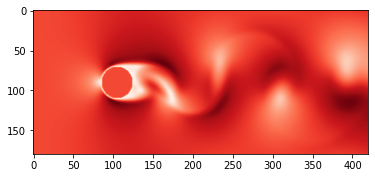

In [ ]:

if __name__ == "__main__":
    %time
    start_time = time.time() # execute only if run as a script
    main_cpu(200000)
    elapsed_time = time.time() - start_time
    print('Sequential Algorithm Took in SECONDS')
    print(elapsed_time)

In [7]:
import plotly.express as px
import numba
from numba import cuda


###### Moving needed data to device global memory ##################################
n_ = [nx,ny]
n_d = cuda.to_device(n_)

v_d = cuda.to_device(v)
t_d = cuda.to_device(t)

# GPU programming methods and trials

Starting out with the gpu_architecture the most import aspects to keep in mind for performance were memory access, management and coalescence.

Starting out, i initially had each step of the sequential algorithm sorted in its own respective kernel. This naive way of gpu programming, although led to some speedup, felt it was missing memory efficiency especially with a local, **embarssingly parallel** algorithm such as Lattice-Boltzmann.

At the beginning brainstorming stages i had the initial_velocity, feq, obstacle and rho vectors in global GPU memory. Each thread was accessing these global vectors each time it needed to run the kernel, which was not at all memory efficient.

I later realised that since many componenets of this algorithm are local to each cell of out grid i.e each thread we could group all of the steps before the streaming part in one kernel and eliminate the need of having global vectors for the aforementioned entities.

At the end it proved to be optimal to avoid these global GPU memory accesses and stick to dealing with **local thread variables** as much as possible.

In [8]:
import math
@cuda.jit
def initial_step(t_d, v_d, n_d, rho_d, feq):
    
    x = cuda.threadIdx.x
    y = cuda.blockIdx.x
    d = cuda.blockDim.x
    nx, ny = n_d[0], n_d[1]
    id = y*d + x
    row = int (id/nx)
    col = int (id%nx)
    rho = rho_d
    if col < nx and row < ny :
        # initial velocity field
        u_0 = uLB * (1 + 1e-4*math.sin(y/ly*2*3.14159))
        u_1 = 0
        t = t_d
        v = v_d
        for i in range(9):
            cu = 3 * (v[i,0]*u_0 + v[i,1]*u_1)
            feq[i,col,row] = rho * t[i] * (1 + cu + 0.5*cu**2 - 3/2 * (u_0*u_0 + u_1*u_1))

In [29]:
@cuda.jit
def iteration_cells(t_d, v_d, n_d, fin, fout, u):
    x = cuda.threadIdx.x
    y = cuda.blockIdx.x
    d = cuda.blockDim.x
    nx, ny = n_d[0], n_d[1]# placing nx and ny in local thread memory to have faster access to these two variables since they will heavily be used throughout the various kernel operations
    id = y*d + x # id of our thread determining whether it's inside our grid or not 
    row = int (id/nx)
    col = int (id%nx)
    

    if col<nx and row<ny:
        feq = cuda.local.array(9, dtype=float64) # Since we do not need a global array of feq encompassing all the points of our grid in main memory, 
        #we are better off making feq a local array belonging to each thread individually since it won't be used by other threads neither will it be used in the iteration that follows the current one
        #Hence feq will only be manipulated locally one iteration at a time by each thread saving us memory access time in the long run and avoiding useless memory allocation on global GPU memory

        t = t_d # vectors t and v are stored as local variables at the start of the kernel for each thread as they will be needed in multiple computations of the Boltzmann Algorithm 
        #Hence by having them in local memory we avoid costly memory access loads
        v = v_d
        # Right Wall flow of our grid
        if col==(nx-1):
            for i in col3:
                fin[i,col,row] = fin[i,col-1,row] 

        # Calculating the macroscopic variables rho, u_0 and u_1 which are distinct to each cell and thus are local thread variables 
        rho = 0    
        u_0 = 0
        u_1 = 0
        for i in range(9):
            rho += fin[i,col,row]    
            u_0 += v[i,0] * fin[i,col,row]
            u_1 += v[i,1] * fin[i,col,row]
        u_0 = u_0/rho
        u_1 = u_1/rho
        
        # inflow conditions left wall fluid coming in
        if col == 0:
            rho = 0
            u_0 = uLB * (1 + 1e-4*math.sin(row/ly*2*3.14159))
            u_1 = 0
            for i_1, i_2 in zip(col2, col3):
                rho += fin[i_1,col,row] + 2*fin[i_2,col,row]
            rho *= 1/(1-u_0)
        
        # update fluid propagation
        u[0,col,row], u[1,col,row] = u_0, u_1
        # Getting each thread's respective feq belonging to one cycle at a time
        for i in range(9):
            cu = 3 * (v[i,0]*u_0 + v[i,1]*u_1)
            usqr = 3/2 * (u_0*u_0 + u_1*u_1)
            feq[i] = rho * t[i] * (1 + cu + 0.5*cu*cu - usqr)

        if col == 0 :
            for i in range(3):
                fin[i,col,row] = feq[i] + fin[8-i,col,row] - feq[8-i]
        # collision computing
        for i in range(9):
            fout[i,col,row] = fin[i,col,row] - omega * (fin[i,col,row] - feq[i])
            
        # Bounce back condition for obstacle cells
        if ((col-cx)**2+(row-cy)**2)< (r**2):
            for i in range(9):
                fout[i,col,row] = fin[8-i,col,row]        


In [22]:
@cuda.jit
def stream_step(v_d, n_d,fin, fout):
    x = cuda.threadIdx.x
    y = cuda.blockIdx.x
    d = cuda.blockDim.x
    nx, ny = n_d[0], n_d[1]
    id = y*d + x
    row = int (id/nx)
    col = int (id%nx)
    if col < nx and row < ny:
        v = v_d
        for i in range(9):
            fin[i,col,row] = fout[i, (col-v[i,0]) % nx, (row-v[i,1]) % ny]

In [30]:
def main_gpu(maxIter):

    threads_per_block = 512 # chose to go with 1D Blocks to ensure coalesence as our threads in the block will be accessing memory column-wise, hence warps will be accessing 32 variables from gpu global memory at a time ensuring optimal alignment 
    blocks_per_grid = int((nx*ny)/threads_per_block) + 1 # this way we flattened our grid and gave each of our threads one cell of the boltzmann system to deal with
    fin     = cuda.device_array((9,nx,ny))
    fout    = cuda.device_array((9,nx,ny))
    u       = cuda.device_array((2,nx,ny))
    import math
    initial_step[blocks_per_grid, threads_per_block](t_d, v_d, n_d, 1, fin)


    for time in range(maxIter):
        # Cells one-iteration
        iteration_cells[blocks_per_grid, threads_per_block](t_d, v_d, n_d, fin, fout, u)
        #For synchronization purposes stream step needed to be put in a separate kernel so that each thread can have contiguous acces to its updated neighboring cells
        stream_step[blocks_per_grid, threads_per_block](v_d, n_d, fin, fout)

    u_cpu = u.copy_to_host()
    figure = np.sqrt(u_cpu[0]*u_cpu[0] + u_cpu[1]*u_cpu[1]).transpose()
    imshow(figure, cmap="Reds")


******************************************

Number of Iterations: 100.000
Algorithm on GPU Took 0.217 SECONDS
Algorithm on CPU Took 1.981 SECONDS
SPEEDUP achieved due to GPU: 912.900 %

******************************************

Number of Iterations: 250.000
Algorithm on GPU Took 0.174 SECONDS
Algorithm on CPU Took 5.006 SECONDS
SPEEDUP achieved due to GPU: 2877.000 %

******************************************

Number of Iterations: 500.000
Algorithm on GPU Took 0.310 SECONDS
Algorithm on CPU Took 10.194 SECONDS
SPEEDUP achieved due to GPU: 3288.400 %

******************************************

Number of Iterations: 750.000
Algorithm on GPU Took 0.401 SECONDS
Algorithm on CPU Took 15.094 SECONDS
SPEEDUP achieved due to GPU: 3764.100 %

******************************************

Number of Iterations: 1000.000
Algorithm on GPU Took 0.515 SECONDS
Algorithm on CPU Took 19.972 SECONDS
SPEEDUP achieved due to GPU: 3878.100 %

******************************************

Number of Iterati

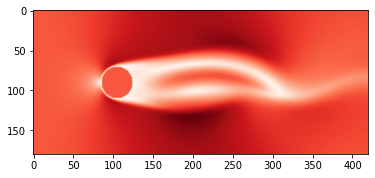

In [32]:
if __name__ == "__main__":
    iter = [100, 250, 500, 750, 1000, 2000, 5000, 10000, 20000]
    gpu_time = []
    cpu_time = []
    speedup_list = []
    time_gained = []
    for i in iter:
        print('\n******************************************\n')
        print('Number of Iterations: {0:.3f}'.format(i))
        start_time = time.time() # execute only if run as a script
        main_gpu(i)
        elapsed_time_gpu = round(time.time() - start_time, 3)
        gpu_time.append(elapsed_time_gpu)
        print('Algorithm on GPU Took {0:.3f} SECONDS'.format(elapsed_time_gpu))
        start_time = time.time()
        main_cpu(i)
        elapsed_time_cpu = round(time.time() - start_time, 3)
        cpu_time.append(elapsed_time_cpu)
        speedup = round(elapsed_time_cpu/elapsed_time_gpu, 3)
        speedup_list.append(speedup)
        timegain = round(elapsed_time_cpu - elapsed_time_gpu, 3)
        time_gained.append(timegain)

        print('Algorithm on CPU Took {0:.3f} SECONDS'.format(elapsed_time_cpu))
        print("SPEEDUP achieved due to GPU: {0:.3f} %".format(speedup*100))
    Time_DIFF = pd.DataFrame({'Number_of_Iterations': iter, 'GPU_TIME': gpu_time,'CPU_TIME(s)': cpu_time,'Time_Gained(s)': time_gained, 'SPEEDUP':speedup_list})
    print('\n******************************************\n')
    print(Time_DIFF)
    Time_DIFF
    benchmark = pd.DataFrame({'Speedup': speedup_list,'Number_of_Iterations': iter})
    fig = px.line(benchmark, x = 'Number_of_Iterations', y = 'Speedup', title = 'Boltzmann Benchmark GPU')
    fig.show()


As we can see starting out with few number of iterations, due to the just in time compilation of numba, the gpu version is not that much faster than the sequential CPU version. 

As the number of iterations performed increases we can notice that the speedup increases accordingly until it hits a plateau at around 1000 iterations.
What is noticeable however is the time saved due to the GPU especially for longer cycles.

This could dramatically help in accelerating simulations of Boltzmann Computational Fluid dynamics in experimental laboratory scenarios.

In [33]:
Time_DIFF

,Number_of_Iterations,GPU_TIME,CPU_TIME(s),Time_Gained(s),SPEEDUP
0,100,0.217,1.981,1.764,9.129
1,250,0.174,5.006,4.832,28.770
2,500,0.310,10.194,9.884,32.884
3,750,0.401,15.094,14.693,37.641
4,1000,0.515,19.972,19.457,38.781
5,2000,0.967,40.200,39.233,41.572
6,5000,2.294,99.250,96.956,43.265
7,10000,4.672,192.578,187.906,41.220
8,20000,9.499,373.094,363.595,39.277


Algorithm on the GPU Took 91.662 SECONDS
The time that was ultimately saved thanks to the GPU is 5268.119 SECONDS


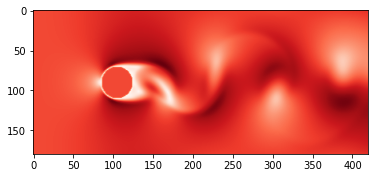

In [31]:
start_time = time.time() # execute only if run as a script
main_gpu(200000)
elapsed_time_gpu = time.time() - start_time
print('Algorithm on the GPU Took {0:.3f} SECONDS'.format(elapsed_time_gpu))
Time_saved = 5359.781 - elapsed_time_gpu
print('The time that was ultimately saved thanks to the GPU is {0:.3f} SECONDS'.format(Time_saved))

#  Conclusion

